# Demonstration of the EMMT

This notebook shows how to use the `EMMT`. We used the data from the [Ballroom](http://mtg.upf.edu/ismir2004/contest/tempoContest/node5.html) dataset. The dataset contains 8 types of music: `Samba`, `Jive`, `Rumba`, `Quickstep`, `Tango`, `Cha Cha`, `VienneseWaltz` and `Waltz`. The model we used in this example, please check in folder models. Here we demonstrated how to use:

1. `AITAH`: The pipeline that transforming audio file based in the configuration file.
2. `PALUN`: The pipeline that generating confusion matrix and LIME plot.


## Implementation of AITAH

The `EMMT` pipeline AITAH automatically generates augmented audio based on configuration `configuration.yml`. It proceeds to run a target classification model to predict the type of Ballroom music for all augmented audio generated by AITAH. Each augmented attribute for every audio will be stored in a YAML file, while the prediction result will be saved as a csv file.


### Set up configuration for audio augmentation pipeline

Here is the following parameters for configuration setup:

- `augmented_audio_save_path`: The path to save the augmented audio outputs.
- `augmented_meta_save_path`: The path to save the augmented metadata.
- `mir_dataset_path`: The path to save the data sources.
- `hpss`: Set up harmonic/percussive source separation.
- `tempo_factor`: Set up logspace time stretch, for the detail of parameter, please check [muda](https://muda.readthedocs.io/en/stable/#).
- `keys`: Set up linear pitch shift, for the detail of parameter, please check [muda](https://muda.readthedocs.io/en/stable/#).
- `drc`: Set up dynamic range compression, for the detail of parameter, please check [muda](https://muda.readthedocs.io/en/stable/#).


In [ ]:
from emmt import aitah

# Create an instance of AudioTransformation from the aitah module, configured via 'configuration.yml'
audio_bank = aitah.AudioTransformation(config_file="configuration.yml")
# Generate augmented audio samples based on the specified number of samples in the configuration
audio_bank.synthesis(n_samples=1)

### Feeding augmented audio samples to the model

Here we demonstrated the CNN model we trained in the thesis.


In [ ]:
import tensorflow as tf

# Load the pre-trained model from the directory specified
model = tf.saved_model.load("models")

In [ ]:
import pandas as pd
import os
from tqdm import tqdm

SAV_PATH = r"metadata_with_predict_results.csv"

if os.path.exists(SAV_PATH):
    sav_df = pd.read_csv(SAV_PATH)
    # Get the list of filenames from sav_df
    existing_filenames = sav_df["file_name"].tolist()

    # Filter out rows in int_df that contain filenames in the existing_filenames list
    int_df = int_df[~int_df["file_name"].isin(existing_filenames)]
    int_df.reset_index(drop=True, inplace=True)
else:
    print(f"File {SAV_PATH} does not exist.")


for i, row in tqdm(int_df.iterrows(), total=int_df.shape[0]):

    # Join the path with the file name for each row in the DataFrame
    audio_file = os.path.join(
        config["augmented_audio_save_path"], row["type"], row["file_name"] + ".wav"
    )
    prediction = model(audio_file)

    int_df.at[i, "y"] = prediction["class_names"].numpy().decode("utf-8")
    int_df.at[i, "y_id"] = prediction["class_ids"].numpy()
    # Get row i from the DataFrame
    current_row = pd.DataFrame(int_df.iloc[i]).T
    current_row.to_csv(SAV_PATH, mode="a", index=False, header=False)

Load the predict results with augmentation metadata.


In [1]:
import pandas as pd

df = pd.read_csv("metadata_with_predict_results_tempo_only.csv")

print(df.shape)
df

(1480, 5)


,file_name,type,rate,y_id,y
0,Media-105416_0_02,Samba,1.000000,0,ChaChaCha
1,Media-105416_5_04,Samba,2.000000,0,ChaChaCha
2,Albums-Fire-02_1_00,Samba,0.500000,5,Tango
3,Media-103502_3_02,Samba,1.000000,6,VienneseWaltz
4,Albums-Fire-02_2_03,Samba,1.414214,0,ChaChaCha
...,...,...,...,...,...
1475,Media-103307_4_04,VienneseWaltz,2.000000,0,ChaChaCha
1476,Media-104211_1_02,VienneseWaltz,1.000000,6,VienneseWaltz
1477,Media-105110_0_01,VienneseWaltz,0.707107,7,Waltz
1478,Albums-Step_By_Step-11_1_00,VienneseWaltz,0.500000,7,Waltz


## Implementation of PALUN

The PALUN pipeline of `EMMT` presents techniques for understanding the outcomes of how the model reacts to modified files, including `accuracy impact summary table`, `confusion matrix`, and `LIME plot`.


### Plotting confusion matrix

In PALUN, you can plot the confusion matrix to visualize the accuracy of classifications by following function:

- `visualize_in_notebook`: Plot the confusion matrix in the notebook.
- `save_as_file`: Save the confusion matrix as a file.
- `visualize_subtracted_in_notebook`: Plot the confusion matrix with the target confusion matrix subtracted from it.
- `save_subtracted_as_file`: Save the confusion matrix with the target confusion matrix subtracted from it as a file.


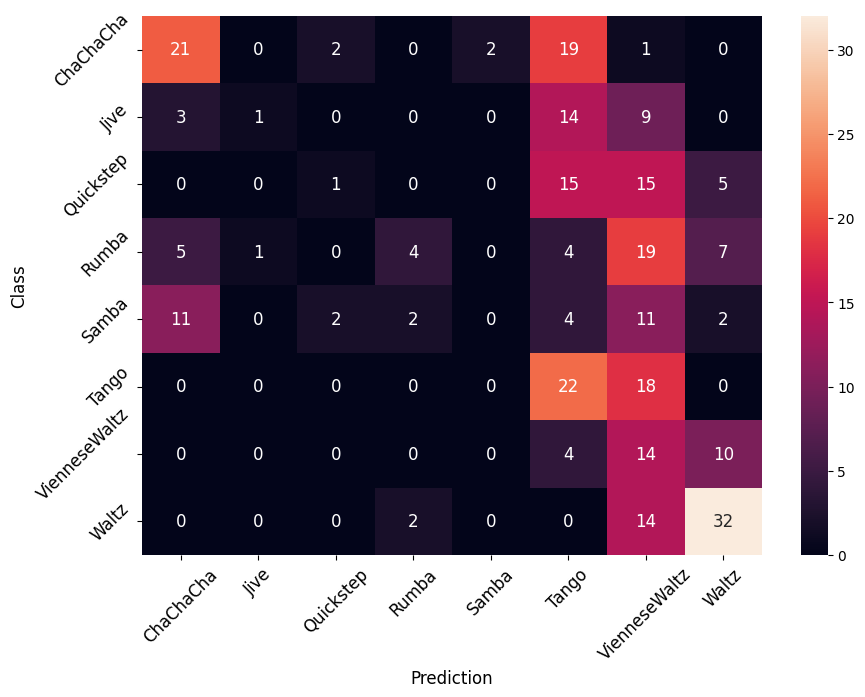

In [2]:
from emmt import palun

# Create an instance of the ConfusionMatrix class from the palun module
palun = palun.ConfusionMatrix()
filtered_df = df[df["rate"] == 0.7071067811865476]


# Use the visualize_in_notebook method to display the confusion matrix in the notebook
# The method takes two arguments: the true labels and the predicted labels
palun.visualize_in_notebook(filtered_df["type"], filtered_df["y"])

In [3]:
# This line of code saves the confusion matrix as a PNG file named "confusion_matrix.png".
# It uses the 'type' column from the dataframe 'df' as the class labels and the 'y' column as the predictions.
palun.save_as_file(
    music_class=df["type"], prediction=df["y"], filename="confusion_matrix.png"
)

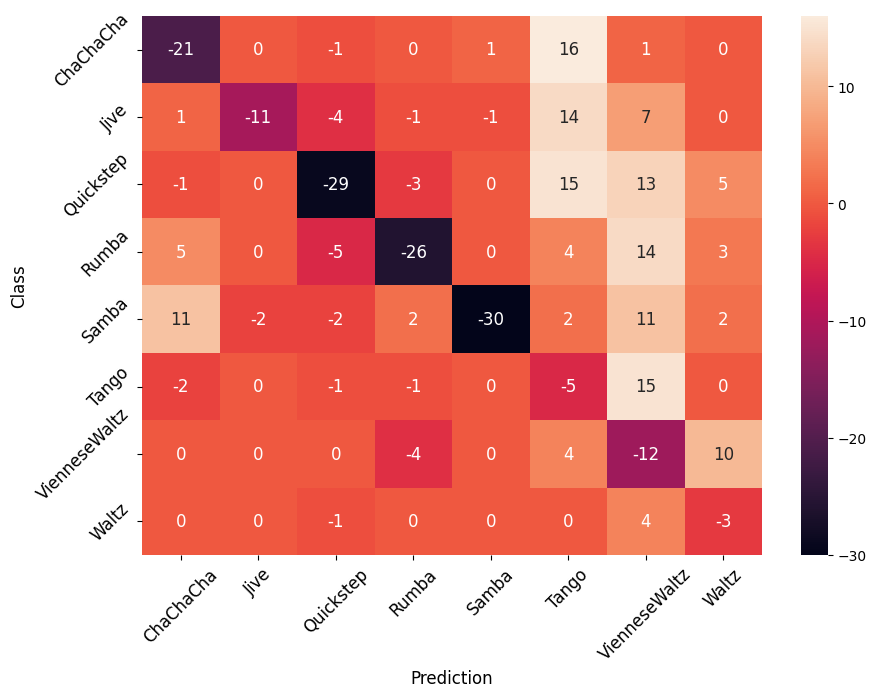

In [4]:
import numpy as np

# Define the target confusion matrix which represents the expected number of classifications
# between each pair of actual and predicted classes.
target_confusion_matrix = np.array(
    [
        [42, 0, 3, 0, 1, 3, 0, 0],  # True ChaChaCha classified as each dance type
        [2, 12, 4, 1, 1, 0, 2, 0],  # True Jive classified as each dance type
        [1, 0, 30, 3, 0, 0, 2, 0],  # True Quickstep classified as each dance type
        [0, 1, 5, 30, 0, 0, 5, 4],  # True Rumba classified as each dance type
        [0, 2, 4, 0, 30, 2, 0, 0],  # True Samba classified as each dance type
        [2, 0, 1, 1, 0, 27, 3, 0],  # True Tango classified as each dance type
        [0, 0, 0, 4, 0, 0, 26, 0],  # True VienneseWaltz classified as each dance type
        [0, 0, 1, 2, 0, 0, 10, 35],  # True Waltz classified as each dance type
    ]
)

# List of class names corresponding to the dance types in the confusion matrix.
classes = [
    "ChaChaCha",
    "Jive",
    "Quickstep",
    "Rumba",
    "Samba",
    "Tango",
    "VienneseWaltz",
    "Waltz",
]

# Visualize the difference between the target confusion matrix and the actual confusion matrix
# derived from the 'type' and 'y' columns of the dataframe 'df'. This visualization helps in
# understanding how the predicted classifications deviate from the expected ones.
palun.visualize_subtracted_in_notebook(
    target_classes=classes,
    target_confusion_matrix=target_confusion_matrix,
    music_class=filtered_df["type"],
    prediction=filtered_df["y"],
)

### Plotting LIME explanation

`EMMT` also implements the LIME technique for interpreting the MIR task model. The method centers on training Logistic Regression with Lasso regularization on transformed audio attributes, to estimate the forecasts of the CNN model underneath. Its objective is to comprehend the reasoning behind a specific prediction made by the CNN model, with the explanatory model reducing loss and complexity while closely imitating the original model’s forecasts.

You can plot LIME explanation by following function:

- `show_lime_explanation`: Plot the LIME explanation in the notebook.
- `save_lime_as_file`: Save the LIME explanation as a file.


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


df = pd.read_csv("metadata_with_predict_results_all.csv")
df["preset_id"] = le.fit_transform(df["preset"])
print(df.columns)
df.head()

Index(['file_name', 'type', 'n_semitones', 'rate', 'preset', 'hpss', 'y_id',
       'y', 'preset_id'],
      dtype='object')


,file_name,type,n_semitones,rate,preset,hpss,y_id,y,preset_id
0,Media-103715_30_hpss,Samba,-2.0,0.707107,radio,1,6,VienneseWaltz,4
1,Media-103715_30,Samba,-2.0,0.707107,radio,0,6,VienneseWaltz,4
2,Media-103715_50_hpss,Samba,1.0,0.707107,film light,1,7,Waltz,0
3,Media-103715_50,Samba,1.0,0.707107,film light,0,5,Tango,0
4,Media-103715_70_hpss,Samba,-1.0,1.000000,music light,1,7,Waltz,2


In [6]:
from emmt import palun

lime_explanation = palun.LimeExplainer()
features = ["n_semitones", "rate", "hpss", "preset_id"]
instance = df.iloc[0][features]
print(instance)

n_semitones        -2.0
rate           0.707107
hpss                  1
preset_id             4
Name: 0, dtype: object


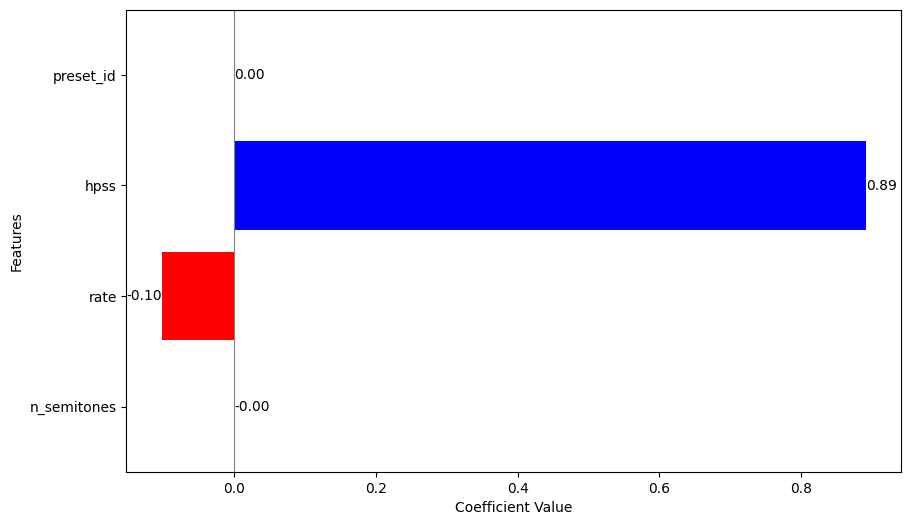

In [7]:
lime_explanation.show_lime_explanation(
    local_data=df[features],
    predictions=df["y_id"],
    instance=instance,
    features=features,
)

In [8]:
lime_explanation.save_lime_as_file(
    filename="lime_explanation.png",
    local_data=df[features],
    predictions=df["y_id"],
    instance=instance,
    features=features,
)